# <center> Santiment Hands On Blockchain Analytics Tutorial </center>
# <center><b> Pumps&Dumps on Centralized Exchanges </center>

## Welcome to Santiment Hands On Tutorial!
Next hour we will be speaking about:
- How in Santiment we think about Ethereum data
- What is the difference between Centralized and Decentralized exchanges
- Pumps on centralized Exchanges
- Conclusions and thoughts

## <b> How we think about Ethereum data

<b> Challenges </b>
- Dealing with LARGE amount of data
- Crunching different blockchain types (UTXO and account-based)
- Maintaining real-time systems
- Providing fault-tolerance

Data Engineering starts with quering blockchain fullnode and ends in the database with analyzable data format.

How to export the Data: https://github.com/santiment/eth-exporter

Think about Ethereum data from transactions perspective (<b>transaction</b> = unit of data)

<b>Transfer Transaction:</b>
- Timestamp (datetime or blockNumber)
- Sender
- Receiver
- Sended amount
- Token (ETH, ERC20, etc)
- TransactionHash

## <b> Centralized and Decentralized Exchanges

<b>Decentralized Exchanges (DEX):</b>
- is a contract stored onchain and executed by EVM (in a case of Ethereum)
- to bet you need to send the transaction
- every trade is stored in the blockchain
- do not owe users' funds
- 100% transparent
- may have or may not have UI

DEXes:
- IDEX
- Kyber
- Oasis etc..


*may not work with ETH but with WETH or KyberETH

<b>Сentralized Exchanges (DEX):</b>
- is a real-world entity
- owe custodian addresses (hot/cold wallets)
- trades happen on the exchange engine and are not stored in the blockchain
- do owe users' funds
- non transparent
- intercation via UI

CEXes:
- [Binance](https://etherscan.io/address/0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be)
- [Bitfinex](https://etherscan.io/address/0x876eabf441b2ee5b5b0554fd502a8e0600950cfa)
- [Huobi](https://etherscan.io/address/0xd8a83b72377476d0a66683cde20a8aad0b628713)
- [Coinbase](https://etherscan.io/address/0x89135c5ea509a1395287ddcdeb1ec307aed78c15) etc..

<img src="exchanges.png">

<b> Deposit and Withdrawal addresses</b>
https://etherscan.io/address/0xc96d9e6361d344781eae1314b306cfbd73696606

### [Sanpy](https://github.com/santiment/sanpy) Setup

In [1]:
# ! pip3 install sanpy

In [10]:
# ! pip3 install fbprophet

In [17]:
import pandas as pd
import numpy as np
import datetime
import san
from fbprophet import Prophet

from utils import fancy_plot, get_san_metric
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from keys import KEY_0
san.ApiConfig.api_key = KEY_0

In [3]:
from_date = '2017-01-01'
to_date = '2019-11-01'
asset = 'ethereum'
interval = '1d'

# create batch object
batch = san.Batch()

# create a request
batch.get(
    f'daily_active_addresses/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)
batch.get(
    f'daily_active_deposits/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)
batch.get(
    f'prices/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)

# execute the request
[daa, dad, price] = batch.execute()

# merge dataframes
data = daa.rename(columns={'value':'activeAddresses'}).join(dad).join(price['priceUsd'])

# take a look
data.head()

,activeAddresses,activeDeposits,priceUsd
datetime,,,
2017-01-01 00:00:00+00:00,13762,4633,8.17257
2017-01-02 00:00:00+00:00,14982,5058,8.37851
2017-01-03 00:00:00+00:00,14535,4753,9.72525
2017-01-04 00:00:00+00:00,17600,5954,11.25160
2017-01-05 00:00:00+00:00,18489,6147,10.25440


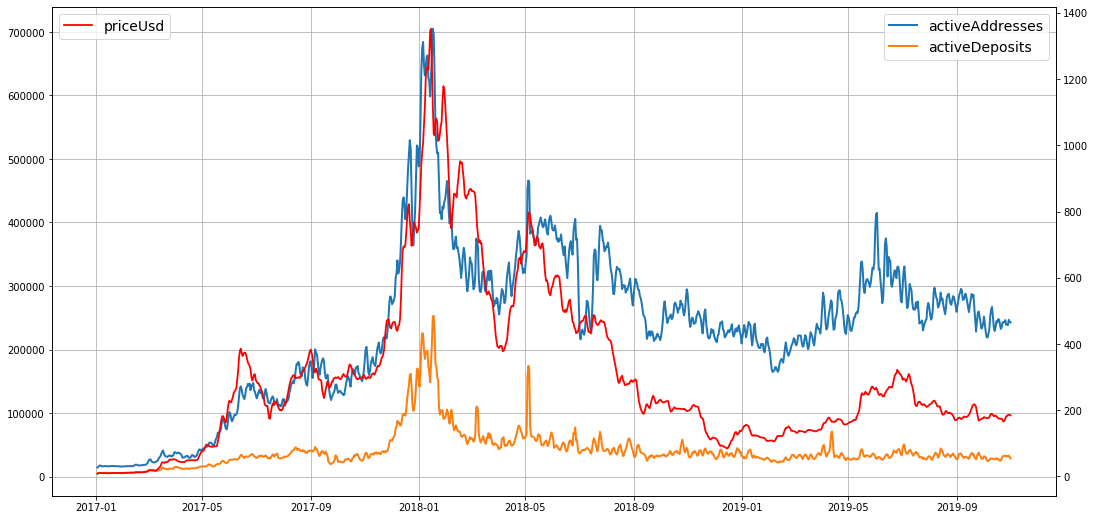

In [4]:
# historical glimpse
fancy_plot(data.rolling(3).mean(), ['activeAddresses', 'activeDeposits'], 'priceUsd')

## <b> Pumps on Centralized Exchanges

- no way to see what's inside CEX
- but it's possible to observe the activity of CEX' wallets

**Assumption:**
There's an abnormal onchain activity before the pump.

**Metric to observe**: exchange flow balance

In [3]:
from_date = '2018-06-01' # skip bullrun
to_date = '2019-11-01'
asset = 'santiment'

ex_flow = get_san_metric(from_date, to_date, 'exchange_funds_flow', asset, interval='1d', iterate_over_days=700)
price = get_san_metric(from_date, to_date, 'prices', asset, interval='1h', iterate_over_days=120)

data = price.join(ex_flow).fillna(0)
data.head()

,marketcap,priceBtc,priceUsd,volume,inOutDifference
datetime,,,,,
2018-06-01 00:00:00,77922557,0.000166,1.24357,1296560,0.0
2018-06-01 01:00:00,77573539,0.000165,1.23800,1283310,0.0
2018-06-01 02:00:00,78023440,0.000166,1.24518,1303430,0.0
2018-06-01 03:00:00,77776558,0.000166,1.24124,1306730,0.0
2018-06-01 04:00:00,77420021,0.000165,1.23555,1293790,0.0


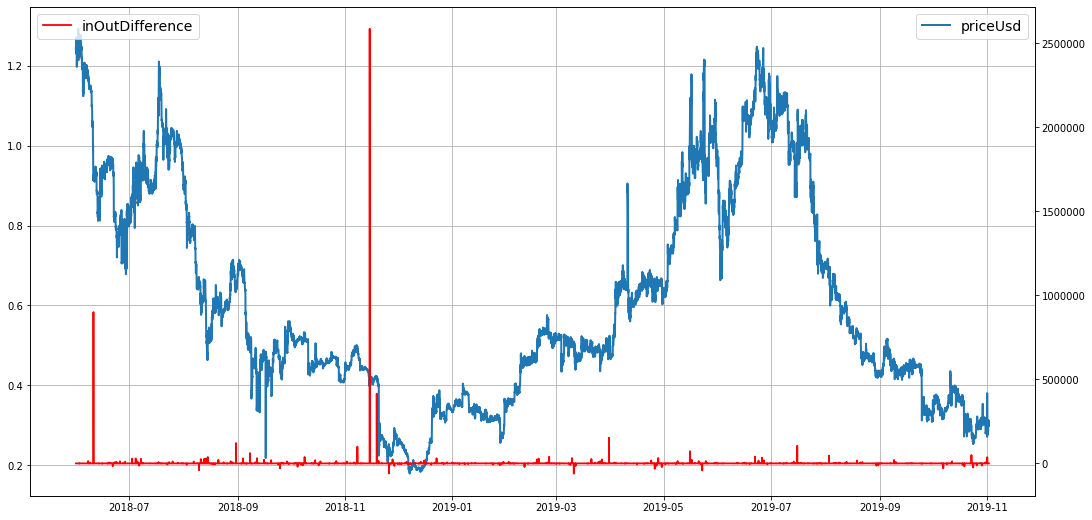

In [4]:
fancy_plot(data, ['priceUsd'], 'inOutDifference')

<b> How to define abnormal activity? </b>
- Statistical way (Granger test, Event study, etc)
- Backtest it!

In order to create backtesting strategy you have to define 2 things:
- when to BUY (1)
- when to SELL (2)

**1)** In order to specify **"entry point"**: create a signal on top of the metric (abnormal exchange flow => buy!)

How to define an "abnormal" behaviour of the metric?
- simple method (>= rolling mean value; outstanding values)
- Facebook approach (actual value is outside the predicted confidence interval)
- [Google approach](https://drive.google.com/file/d/1TyfMYV_hUmHbAKdY6iSnH_LqGkid3Srt/view)


**2)** (tricky one) In order to specify **exit point**:
- naive way (price thresholds)
- signalling (create signals on top of other metrics)
- ML approach (predict tops, haven't try it yet!)
- your ideas? :)

## Detect anomalies: [Prophet](https://github.com/facebook/prophet/tree/master/python)

<img src="prophet.png">

In [5]:
ex_flow_train = get_san_metric(
    start='2018-01-01',
    end='2019-11-01',
    metric='exchange_funds_flow',
    asset='santiment',
    interval='1d', 
    iterate_over_days=700
)

In [6]:
# transform data to prophet-readable format
ex_flow_train = ex_flow_train.reset_index()
ex_flow_train.columns = ['ds', 'y']

In [7]:
model = Prophet(seasonality_mode='additive')

In [8]:
model.fit(ex_flow_train[ex_flow_train['ds'] < ex_flow.index[0]])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=30)
pred = model.predict(future)

In [15]:
pred[['ds', 'yhat_lower', 'yhat_upper']][pred['ds'] > ex_flow.index[0]]

,ds,yhat_lower,yhat_upper
152,2018-06-02,-334604.365352,418980.156389
153,2018-06-03,-338696.303690,439881.578160
154,2018-06-04,-379345.376632,404750.577250
155,2018-06-05,-333646.825528,380440.213746
156,2018-06-06,-331819.435699,408299.926379
157,2018-06-07,-349543.569435,389398.924941
158,2018-06-08,-506218.544857,255026.156778
159,2018-06-09,-329819.344915,447181.688552
160,2018-06-10,-343248.064934,416334.263003
161,2018-06-11,-329295.170639,415099.007850


In [29]:
gap = (datetime.datetime.strptime(to_date, '%Y-%m-%d') - datetime.datetime.strptime(from_date, '%Y-%m-%d')).days
predicted = pd.DataFrame(None)

for month in range(gap//30 + 1):
    model = Prophet(seasonality_mode='additive')
    model.fit(ex_flow_train[ex_flow_train['ds'] < ex_flow.index[month]])
    future = model.make_future_dataframe(periods=30)
    pred = model.predict(future)
    predicted = predicted.append(
        pred[['ds', 'yhat_lower', 'yhat_upper']][pred['ds'] > ex_flow.index[month]]
    )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [30]:
predicted

,ds,yhat_lower,yhat_upper
152,2018-06-02,-361887.990371,423756.539568
153,2018-06-03,-333379.345044,409124.313170
154,2018-06-04,-378478.243768,420894.502860
155,2018-06-05,-360599.751440,424985.576106
156,2018-06-06,-371926.617139,386400.364260
...,...,...,...
193,2018-07-13,-464642.258612,250507.287499
194,2018-07-14,-281111.096124,408534.808039
195,2018-07-15,-334880.806346,445717.428702
196,2018-07-16,-297254.430597,456331.686522


### Simple strategy

In [147]:
def create_strategy(
    df:pd.DataFrame,
    price_name:str,
    signal_name:str,
    gain_to_exit:float,
    loose_to_exit:float,
    max_intervals_to_hodl=np.inf
):

    strategy = df[signal_name].copy()
    state = {'price':None, 'hodl_days': None}

    for t in range(len(strategy)):

        if strategy[t] and not state['price']:  # if signal and asset is not already bought
            # buy asset
            state['price'] = df[price_name][t]
            state['hodl_intervals'] = 0

        elif state['price']:  # if asset is already bought
            if df[price_name][t] > (1 + gain_to_exit) * state['price'] or \
               df[price_name][t] < (1 - loose_to_exit) * state['price'] or \
               state['hodl_intervals'] > max_intervals_to_hodl:  
                # sell asset
                state['price'], state['hodl_intervals'] = None, None
                strategy[t] = False
            else:
                # keep hodling
                strategy[t] = True
                state['hodl_intervals'] += 1

    return strategy

## <b> Conclusions

Thanks!